In [1]:
import json
import os
from utils import *
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import dot
from numpy.linalg import norm
from resume_fields import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument
from scipy.spatial.distance import cosine

# Semantic similarities. 


## responsibilities

In [30]:
# with open("parsed_resume_jsons/baseline_comparison.json", "r") as f:
#     baseline_comparison = json.load(f)
    
with open("new_baseline_comparison.json", "r") as f:
    baseline_comparison = json.load(f)
baseline = baseline_comparison["baseline"]
chatgpt = baseline_comparison["chatgpt"]
llama2 = baseline_comparison["llama2"]
keys = list(baseline.keys())

In [3]:
temp1 = llama2[keys[0]][EXPERIENCE][0][RESPONSIBILITIES]
temp2 = chatgpt[keys[0]][EXPERIENCE][0][RESPONSIBILITIES]

nlp = spacy.load("en_core_web_md")
doc1 = nlp(temp1)
doc2 = nlp(temp2)

similarity = doc1.similarity(doc2)
print(similarity)


0.9974236330629269


In [4]:
for k in keys:
    for resp in llama2[k][EXPERIENCE]:
        try:
            resp[RESPONSIBILITIES]# = resp[RESPONSIBILITIES].replace("\n", " ")
        except:
            print(k)
    

00690.txt
20088.txt


Note:   
00690.txt has "GPA" as "responsibility" for 1 experience    
20088.txt has 1 missing "responsibility" for 1 experience

In [5]:
[llama2[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] if RESPONSIBILITIES in llama2[keys[k]][EXPERIENCE][i] else "NoneNone" for k in range(len(keys)) for i in range(len(llama2[keys[k]][EXPERIENCE]))].count("NoneNone")

2

In [89]:
chatgpt_responsibilities = [chatgpt[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for k in range(len(keys)) for i in range(len(chatgpt[keys[k]][EXPERIENCE]))]
llama2_responsibilities = [llama2[keys[k]][EXPERIENCE][i][RESPONSIBILITIES].replace("\ufffd", "").replace("- ", "") if RESPONSIBILITIES in llama2[keys[k]][EXPERIENCE][i] else "" for k in range(len(keys)) for i in range(len(llama2[keys[k]][EXPERIENCE]))]
baseline_responsibilities = [baseline[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for k in range(len(keys)) for i in range(len(baseline[keys[k]][EXPERIENCE]))]

llama2_responsibilities = [
    [llama2[keys[k]][EXPERIENCE][i][RESPONSIBILITIES].replace("\ufffd", "").replace("- ", "") if RESPONSIBILITIES in llama2[keys[k]][EXPERIENCE][i] else "" for i in range(len(llama2[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
chatgpt_responsibilities = [
    [chatgpt[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for i in range(len(chatgpt[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
baseline_responsibilities = [
    [baseline[keys[k]][EXPERIENCE][i][RESPONSIBILITIES] for i in range(len(baseline[keys[k]][EXPERIENCE]))] for k in range(len(keys))
]
assert len(llama2_responsibilities) == len(chatgpt_responsibilities) == len(baseline_responsibilities) == 118

llama2_responsibilities = [" ".join(llama2_responsibilities[i]) for i in range(len(llama2_responsibilities))]
chatgpt_responsibilities = [" ".join(chatgpt_responsibilities[i]) for i in range(len(chatgpt_responsibilities))]
baseline_responsibilities = [" ".join(baseline_responsibilities[i]) for i in range(len(baseline_responsibilities))]
assert len(llama2_responsibilities) == len(chatgpt_responsibilities) == len(baseline_responsibilities) == 118

477

In [9]:

processed_chatgpt_responsibilities = list(nlp.pipe(chatgpt_responsibilities))
processed_llama2_responsibilities = list(nlp.pipe(llama2_responsibilities))
processed_baseline_responsibilities = list(nlp.pipe(baseline_responsibilities))

chatgpt_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_chatgpt_responsibilities, processed_baseline_responsibilities)])
llama2_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_llama2_responsibilities, processed_baseline_responsibilities)])

In [17]:
weights = np.array([len(temp.split()) for temp in baseline_responsibilities])
weights = weights / weights.sum()

weighted_chatgpt_baseline_similarities = chatgpt_baseline_similarities * weights
weighted_llama2_baseline_similarities = llama2_baseline_similarities * weights

In [21]:
weighted_chatgpt_baseline_similarities 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [31]:
weighted_average_chatgpt_baseline_similarity = weighted_chatgpt_baseline_similarities.sum()
weighted_average_llama2_baseline_similarity = weighted_llama2_baseline_similarities.sum()
print(weighted_average_chatgpt_baseline_similarity)
print(weighted_average_llama2_baseline_similarity)

0.9902041386695454
0.9922120063386655


In [33]:
df = pd.DataFrame({"chatGPT vs. Baseline": chatgpt_baseline_similarities, "Llama2 vs. Baseline": llama2_baseline_similarities, "weights": weights})
df.to_csv("responsibilities_similarity.csv")
df.describe()

,chatGPT vs. Baseline,Llama2 vs. Baseline,weights
count,118.000000,118.000000,118.000000
mean,0.989502,0.977787,0.008475
std,0.015660,0.110893,0.004905
min,0.927528,0.009889,0.000342
25%,0.983596,0.992475,0.004861
50%,0.997918,0.999298,0.007205
75%,1.000000,0.999963,0.011364
max,1.000000,1.000000,0.021017


In [29]:
descriptive_comparison = pd.concat([pd.Series(chatgpt_baseline_similarities).describe(), pd.Series(llama2_baseline_similarities).describe()], axis=1)
descriptive_comparison.columns = ["ChatGPT", "LLAMA2"]
descriptive_comparison

,ChatGPT,LLAMA2
count,118.000000,118.000000
mean,0.989502,0.977787
std,0.015660,0.110893
min,0.927528,0.009889
25%,0.983596,0.992475
50%,0.997918,0.999298
75%,1.000000,0.999963
max,1.000000,1.000000


118

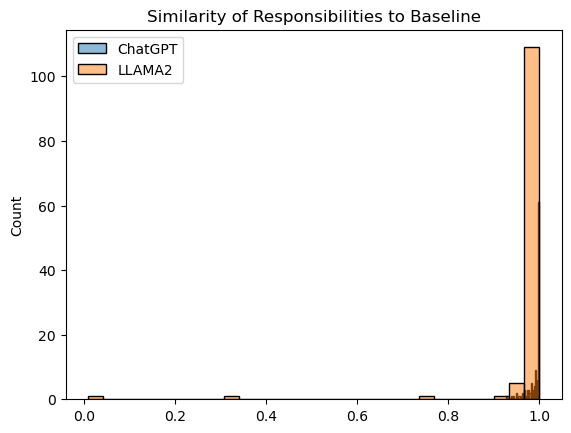

In [34]:
sns.histplot(chatgpt_baseline_similarities, bins=30, alpha = 0.5, label = "ChatGPT")
sns.histplot(llama2_baseline_similarities, bins=30, alpha = 0.5, label = "LLAMA2")
plt.legend()
plt.title("Similarity of Responsibilities to Baseline");

In [9]:
llama2[keys[0]][EXPERIENCE][0][RESPONSIBILITIES]

'Contract position with Cintas through Insight Global. Responsible for coordinating over 100 appointments daily, often valued over $100,000. Performed scheduling duties by making outbound calls to confirm and verify client information. Maintained organization and call data for reports while utilizing Excel and internal databases. Revise and provide SOW upon request.'

## Skills

In [36]:
llama2_skills = [", ".join(llama2[key][SKILLS] + llama2[key][TECHNICAL_SKILLS]).upper() for key in keys]
chatgpt_skills = [", ".join(chatgpt[key][SKILLS] + chatgpt[key][TECHNICAL_SKILLS]).upper() for key in keys]
baseline_skills = [", ".join(baseline[key][SKILLS] + baseline[key][TECHNICAL_SKILLS]).upper() for key in keys]

processed_chatgpt_skills = list(nlp.pipe(chatgpt_skills))
processed_llama2_skills = list(nlp.pipe(llama2_skills))
processed_baseline_skills = list(nlp.pipe(baseline_skills))

chatgpt_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_chatgpt_skills, processed_baseline_skills)])
llama2_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_llama2_skills, processed_baseline_skills)])

skill_similarities = pd.DataFrame({"ChatGPT": chatgpt_baseline_similarities, "LLAMA2": llama2_baseline_similarities})
skill_similarities.to_csv("skill_similarity.csv")
skill_similarities.describe()

/var/folders/bt/709h7c513ld30l7ynqg_cv0c0000gn/T/ipykernel_68201/196020786.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  chatgpt_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_chatgpt_skills, processed_baseline_skills)])
/var/folders/bt/709h7c513ld30l7ynqg_cv0c0000gn/T/ipykernel_68201/196020786.py:10: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  llama2_baseline_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(processed_llama2_skills, processed_baseline_skills)])


,ChatGPT,LLAMA2
count,118.000000,118.000000
mean,0.791047,0.828181
std,0.352424,0.297983
min,0.000000,0.000000
25%,0.744472,0.858615
50%,0.998425,0.993819
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
# 	ChatGPT	LLAMA2
# count	118.000000	118.000000
# mean	0.791047	0.828181
# std	0.352424	0.297983
# min	0.000000	0.000000
# 25%	0.744472	0.858615
# 50%	0.998425	0.993819
# 75%	1.000000	1.000000
# max	1.000000	1.000000

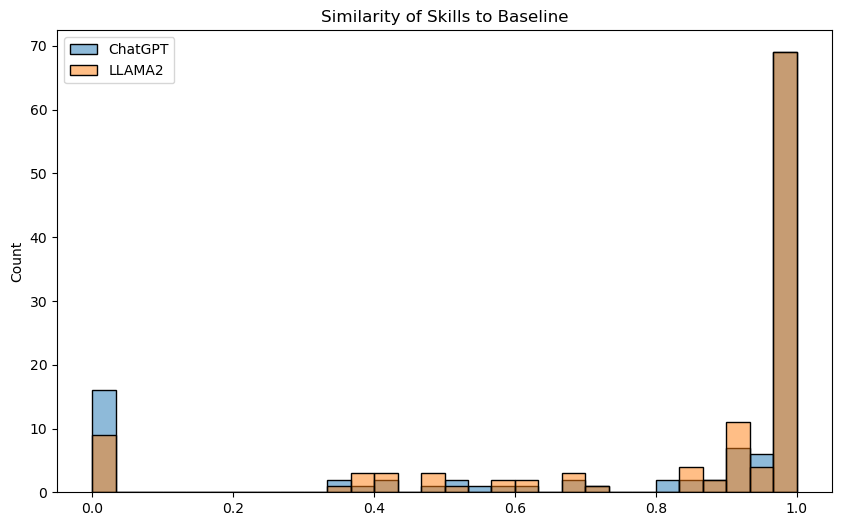

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(chatgpt_baseline_similarities, bins=30, alpha = 0.5, label = "ChatGPT")
sns.histplot(llama2_baseline_similarities, bins=30, alpha = 0.5, label = "LLAMA2")
plt.legend()
plt.title("Similarity of Skills to Baseline");


In [38]:
weights = np.array([0.00790514, 0.00632411, 0.00711462, 0.        , 0.00711462,
       0.01343874, 0.00316206, 0.00948617, 0.00869565, 0.00079051,
       0.01106719, 0.00869565, 0.        , 0.        , 0.00474308,
       0.0055336 , 0.01660079, 0.00395257, 0.01264822, 0.        ,
       0.00237154, 0.01027668, 0.        , 0.00395257, 0.00316206,
       0.0055336 , 0.0173913 , 0.02055336, 0.00395257, 0.        ,
       0.0055336 , 0.00237154, 0.        , 0.01106719, 0.01660079,
       0.0173913 , 0.        , 0.        , 0.00711462, 0.00316206,
       0.0055336 , 0.02213439, 0.00869565, 0.        , 0.01027668,
       0.01343874, 0.0055336 , 0.01027668, 0.        , 0.00948617,
       0.00869565, 0.01185771, 0.01422925, 0.00316206, 0.01027668,
       0.00395257, 0.00790514, 0.00395257, 0.00316206, 0.03003953,
       0.01660079, 0.01106719, 0.        , 0.00790514, 0.        ,
       0.00948617, 0.03794466, 0.00790514, 0.0173913 , 0.00869565,
       0.00395257, 0.00316206, 0.01422925, 0.00711462, 0.        ,
       0.00237154, 0.01501976, 0.        , 0.01185771, 0.00790514,
       0.00869565, 0.00237154, 0.00869565, 0.01264822, 0.00237154,
       0.01264822, 0.00079051, 0.        , 0.00790514, 0.00395257,
       0.01343874, 0.00948617, 0.00474308, 0.03003953, 0.01818182,
       0.00474308, 0.00237154, 0.00395257, 0.01501976, 0.        ,
       0.02371542, 0.02371542, 0.00237154, 0.01343874, 0.00948617,
       0.        , 0.01106719, 0.00948617, 0.01027668, 0.00395257,
       0.00316206, 0.01897233, 0.03320158, 0.00790514, 0.02529644,
       0.00948617, 0.00948617, 0.        ])

print(f"Llama2 weighted average similarity: {np.sum(llama2_baseline_similarities * weights)}")
print(f"ChatGPT weighted average similarity: {np.sum(chatgpt_baseline_similarities * weights)}")

Llama2 weighted average similarity: 0.8564916289883977
ChatGPT weighted average similarity: 0.7784539266202143


In [12]:
chatgpt_with_addtional = [key for key in keys if "Additional_Information" in chatgpt[key] and "Skills" in chatgpt[key]["Additional_Information"]]

In [13]:
getCleanResume('12036.txt')

'IT Technician \nIT Technician IT Technician Velocity Network Erie, PA Work well with team members, but also able to work independently. Hands on experience in administering networks, including configuring and installing cisco networks, and databases. Experience in customer relationship service and resolving issues with critical thinking skills. Work Experience IT Technician Velocity Network March 2018 to Present Helpdesk Analyst Zippo Manufacturing Company March 2017 to March 2018 Responsibilities include answering help desk tickets as they come in, imaging and deploying new PCs, troubleshooting issues with production PCs. Security Officer Springhill Senior Living September 2015 to March 2018 EMT: Responsibilities include patient care, patrolling of grounds, basic maintenance, ability to deescalate situations, and documentation of incidents. Emergency Medical Technician EmergyCare March 2014 to October 2016 Responsibilities include patient care, apparatus upkeep and restocking, docume

In [14]:
chatgpt["12036"]

{'Basic_Info': {'Current_Title': 'IT Technician',
  'Current_Company': 'Velocity Network',
  'Location': 'Erie, PA',
  'Bio': 'Work well with team members, but also able to work independently. Hands on experience in administering networks, including configuring and installing cisco networks, and databases.- Experience in customer relationship service and resolving issues with critical thinking skills.'},
 'Experience': [{'Job_Title': 'IT Technician',
   'Company': 'Velocity Network',
   'Location': 'Erie, PA',
   'Start_Date': 'March 2018',
   'End_Date': 'Present',
   'Responsibilities': 'Helpdesk Analyst Zippo Manufacturing Company March 2017 to March 2018 Responsibilities include answering help desk tickets as they come in, imaging and deploying new PCs, troubleshooting issues with production PCs.'},
  {'Job_Title': 'Security Officer',
   'Company': 'Springhill Senior Living',
   'Location': 'Erie, PA',
   'Start_Date': 'September 2015',
   'End_Date': 'March 2018',
   'Responsibili

In [15]:
llama2["12036"][SKILLS]

['Active Directory (3 years)',
 'backups. (3 years)',
 'cisco (2 years)',
 'Cisco (1 year)',
 'Tech Support',
 'Help Desk',
 'Desktop Support',
 'Service Desk',
 'MSP (2 years)',
 'VPN',
 'Helpdesk Support',
 'Computer Repair',
 'It Specialist',
 'Information Technology',
 'Network Support']

## Education

In [16]:
ed1 = "B.S. in computer science"
ed2 = "Bachelor of Science in Computer Science"
ed3 = "B.S. in CS"
ed4 = "Bachelor of Science in CS"
doc1 = nlp(ed1)
doc2 = nlp(ed2)
doc3 = nlp(ed3)
doc4 = nlp(ed4)
print(doc1.similarity(doc2))
print(doc1.similarity(doc3))
print(doc1.similarity(doc4))
print(doc2.similarity(doc3))
print(doc2.similarity(doc4))
print(doc3.similarity(doc4))
# cannot use similarity to compare degree
# may need to fine-tune pre-trained word vectors

0.8123675359994781
0.8110791025680146
0.7870080249698532
0.6580217658597927
0.9351118015190473
0.8026872767618556


In [42]:
llama2_degrees = [llama2[key][EDUCATION][ii]['Degree'] for key in keys for ii in range(len(llama2[key][EDUCATION]))]
chatgpt_degrees = [chatgpt[key][EDUCATION][ii]['Degree'] for key in keys for ii in range(len(chatgpt[key][EDUCATION]))]
baseline_degrees = [baseline[key][EDUCATION][ii]['Degree'] for key in keys for ii in range(len(baseline[key][EDUCATION]))]

llama2_field = [llama2[key][EDUCATION][ii]['Field'] for key in keys for ii in range(len(llama2[key][EDUCATION]))]
chatgpt_field = [chatgpt[key][EDUCATION][ii]['Field'] for key in keys for ii in range(len(chatgpt[key][EDUCATION]))]
baseline_field = [baseline[key][EDUCATION][ii]['Field'] for key in keys for ii in range(len(baseline[key][EDUCATION]))]


In [18]:
print(llama2_degrees[:5])
print(chatgpt_degrees[:5])
print(baseline_degrees[:5])

['B.S in Computer Science', 'Bachelor of Science in Information Technology', 'CS', '', 'Bachelor of Science in Management Information Systems']
['B.S', 'Bachelor of Science', '', '', 'Bachelor of Science']
['B.S', 'Bachelor of Science', 'CS', '', 'Bachelor of Science in Management Information Systems']


In [19]:
print(llama2_field[:5])
print(chatgpt_field[:5])
print(baseline_field[:5])


['', '', '', '', '']
['Computer Science', 'Information Technology', '', '', 'Management Information Systems']
['Computer Science', 'Information Technology', '', '', '']


In [43]:
def convert_education(education):
    degree = education[DEGREE] if DEGREE in education else ""
    field = education[FIELD] if FIELD in education else ""
    school = education[INSTITUTION] if INSTITUTION in education else ""
    Graduation_Date = education[GRADUATION_DATE] if GRADUATION_DATE in education else ""
    
    if len(field) > 0:
        field = "in " + field
    return f"{degree} {field} from {school} "

# llama2_education = [convert_education(llama2[key][EDUCATION][ii]) for key in keys for ii in range(len(llama2[key][EDUCATION]))]
# chatgpt_education = [convert_education(chatgpt[key][EDUCATION][ii]) for key in keys for ii in range(len(chatgpt[key][EDUCATION]))]
# baseline_education = [convert_education(baseline[key][EDUCATION][ii]) for key in keys for ii in range(len(baseline[key][EDUCATION]))]

llama2_education = []
chatgpt_education = []
baseline_education = []

for i, key in enumerate(keys):
    baseline_educations = baseline[key][EDUCATION]
    chatgpt_educations = chatgpt[key][EDUCATION]
    llama2_educations = llama2[key][EDUCATION]
    
    for ii in range(len(baseline_educations)):
        baseline_education.append(convert_education(baseline_educations[ii]))
        try:
            chatgpt_education.append(convert_education(chatgpt_educations[ii]))
        except:
            chatgpt_education.append(convert_education(dict()))
        try:
            llama2_education.append(convert_education(llama2_educations[ii]))
        except:
            llama2_education.append(convert_education(dict()))
            
    if len(llama2_educations) > len(baseline_educations):
        for ii in range(len(baseline_educations), len(llama2_educations)):
            baseline_education.append(convert_education(dict()))
            llama2_education.append(convert_education(llama2_educations[ii]))
            try:
                chatgpt_education.append(convert_education(chatgpt_educations[ii]))
            except:
                chatgpt_education.append(convert_education(dict()))
                
    if len(chatgpt_educations) > len(baseline_educations):
        for ii in range(len(baseline_educations), len(chatgpt_educations)):
            baseline_education.append(convert_education(dict()))
            chatgpt_education.append(convert_education(chatgpt_educations[ii]))
            try:
                llama2_education.append(convert_education(llama2_educations[ii]))
            except:
                llama2_education.append(convert_education(dict()))

(baseline_education[:5])

['B.S in Computer Science from University of Maryland ',
 'Bachelor of Science in Information Technology from Brigham Young University ',
 'CS  from Dixie State College ',
 '  from Snow Canyon High School ',
 'Bachelor of Science in Management Information Systems  from Rowan University ']

In [44]:
baseline_educations = {key: [convert_education(baseline[key][EDUCATION][ii]) for ii in range(len(baseline[key][EDUCATION]))] for key in keys}
chatgpt_educations = {key: [convert_education(chatgpt[key][EDUCATION][ii]) for ii in range(len(chatgpt[key][EDUCATION]))] for key in keys}
llama2_educations = {key: [convert_education(llama2[key][EDUCATION][ii]) for ii in range(len(llama2[key][EDUCATION]))] for key in keys}

temp = [baseline_educations, chatgpt_educations, llama2_educations]
for key in keys:
    max_len = max(len(baseline_educations[key]), len(chatgpt_educations[key]), len(llama2_educations[key]))
    for model in temp:
        if len(model[key]) < max_len:
            model[key].append(convert_education(dict()))

In [49]:
doc1 = nlp(baseline_educations[keys[3]][0])
doc2 = nlp(baseline_educations[keys[8]][0])
print(doc1)
print(doc2)
doc1.similarity(doc2)

Bachelor of Science in Management Information Systems  from Rowan University 
Master's in Computer Science in Computer Science from Acharya Nagarjuna University 


0.8820129424238462

In [50]:
for key in keys:
    llamaTemp = llama2[key][EDUCATION]
    chatgptTemp = chatgpt[key][EDUCATION]
    baselineTemp = baseline[key][EDUCATION]
    if len(llamaTemp) != len(chatgptTemp) or len(llamaTemp) != len(baselineTemp):
        print(key)
        print(f"LLAMA2: {len(llamaTemp)}")
        print(f"ChatGPT: {len(chatgptTemp)}")
        print(f"Baseline: {len(baselineTemp)}")
        print()
        

26375
LLAMA2: 1
ChatGPT: 2
Baseline: 2

21753
LLAMA2: 1
ChatGPT: 0
Baseline: 1

21263
LLAMA2: 2
ChatGPT: 2
Baseline: 1

26346
LLAMA2: 1
ChatGPT: 0
Baseline: 1

24869.txt
LLAMA2: 1
ChatGPT: 1
Baseline: 2

00690.txt
LLAMA2: 1
ChatGPT: 3
Baseline: 3

22801.txt
LLAMA2: 4
ChatGPT: 4
Baseline: 3

01538.txt
LLAMA2: 2
ChatGPT: 3
Baseline: 3

16515.txt
LLAMA2: 1
ChatGPT: 1
Baseline: 0

03771.txt
LLAMA2: 1
ChatGPT: 0
Baseline: 0

17266.txt
LLAMA2: 2
ChatGPT: 1
Baseline: 2



In [45]:
llama2_eudcation_processed = list(nlp.pipe(llama2_education))
chatgpt_eudcation_processed = list(nlp.pipe(chatgpt_education))
baseline_eudcation_processed = list(nlp.pipe(baseline_education))

chatgpt_baseline_eudcation_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(chatgpt_eudcation_processed, baseline_eudcation_processed)])
llama2_baseline_eudcation_similarities = np.array([doc1.similarity(doc2) for doc1, doc2 in zip(llama2_eudcation_processed, baseline_eudcation_processed)])
print(chatgpt_baseline_eudcation_similarities.mean())
print(llama2_baseline_eudcation_similarities.mean())

0.9571248858878141
0.9407537262152673


In [46]:
all_education = llama2_education + chatgpt_education + baseline_education
tokenized_education = [[token.text for token in nlp(education.lower())] for education in all_education]
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_education)]

model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)

e1 = "Bachelor in Informatics Engineering  from University of Matanzas (Graduation Date: 2012)"
e2 = "Bachelor of Science in Management Information Systems  from Rowan University (Graduation Date: May 2017)"
vec1 = model.infer_vector(e1.split())
vec2 = model.infer_vector(e2.split())
similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
similarity

0.9767941

### Use Jaccard


llama2 mean jaccard: 0.9011068229016947
chatgpt mean jaccard: 0.9399520560719655


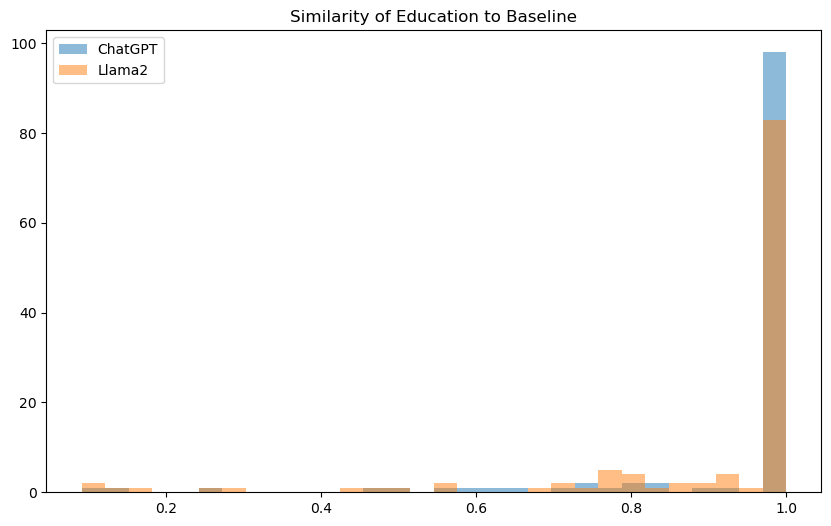

In [51]:
def compute_jaccard(text1, text2):
    # Tokenize the texts and convert to sets
    set1 = set(text1.split())
    set2 = set(text2.split())
    
    if not set1 and not set2:  # if both sets are empty
        return 1.0
    
    return len(set1.intersection(set2)) / len(set1.union(set2))

chatgpt_education_jaccard = {key: np.mean([compute_jaccard(education, baseline_educations[key][ii]) for ii, education in enumerate(chatgpt_educations[key])]) for key in keys}
llama2_education_jaccard = {key: np.mean([compute_jaccard(education, baseline_educations[key][ii]) for ii, education in enumerate(llama2_educations[key])]) for key in keys}


chatgpt_education_jaccard = pd.Series(chatgpt_education_jaccard)
llama2_education_jaccard = pd.Series(llama2_education_jaccard)

education_jaccad_comparison = pd.DataFrame({"ChatGPT": chatgpt_education_jaccard, "Llama2": llama2_education_jaccard})

print(f"llama2 mean jaccard: {llama2_education_jaccard.mean()}")
print(f"chatgpt mean jaccard: {chatgpt_education_jaccard.mean()}")
plt.figure(figsize=(10, 6))
plt.hist(chatgpt_education_jaccard, bins=30, alpha = 0.5, label = "ChatGPT")
plt.hist(llama2_education_jaccard, bins=30, alpha = 0.5, label = "Llama2");
plt.legend()
plt.title("Similarity of Education to Baseline");

In [52]:
education_jaccad_comparison.to_csv("education_jaccard.csv")

In [53]:
education_jaccad_comparison.describe()

,ChatGPT,Llama2
count,117.000000,117.000000
mean,0.939952,0.901107
std,0.167583,0.210272
min,0.090909,0.090909
25%,1.000000,0.909091
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [45]:
res = "17230.txt"
print(f"llama2 output: {llama2_educations[res]}")
print(f"chatgpt output: {chatgpt_educations[res]}")
print(f"baseline output: {baseline_educations[res]}")

llama2 output: ['Bachelors of Science in Information Technology  from Franklin University (Graduation Date: August 2017)', 'Master of Science in Cyber Security Management  from Kaplan University (Graduation Date: )', 'Associate of Applied Science in Network Engineering  from Sinclair Community College (Graduation Date: June 2015)']
chatgpt output: ['Bachelors of Science in Information Technology from Franklin University (Graduation Date: August 2017)', 'Master of Science in Cyber Security Management from Kaplan University (Graduation Date: March 2017)', 'Associate of Applied Science in Network Engineering from Sinclair Community College (Graduation Date: June 2015)']
baseline output: ['Bachelors of Science in Information Technology from Franklin University (Graduation Date: August 2017)', 'Master of Science in Cyber Security Management from Kaplan University (Graduation Date: March 2017)', 'Associate of Applied Science in Network Engineering from Sinclair Community College (Graduation 

In [29]:
(baseline[keys[19]][EDUCATION])

[{'Degree': 'Bachelor of Arts',
  'Field': 'Telecommunications',
  'Institution': 'The Pennsylvania State University',
  'Location': '',
  'Graduation_Date': '2015'}]

In [30]:
chatgpt_baseline_eudcation_similarities

array([1.        , 1.        , 0.95098489, 0.94997982, 0.99999996,
       0.99048519, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98386803,
       1.        , 1.        , 1.        , 1.        , 0.89589841,
       1.        , 0.95543041, 1.        , 1.        , 1.        ,
       0.67618408, 1.        , 0.92638448, 0.90343085, 1.00000009,
       0.99999981, 0.77201851, 0.7636605 , 1.        , 1.        ,
       1.        , 0.91600559, 1.        , 1.        , 0.98105331,
       0.99999989, 0.62166191, 0.62166191, 0.9731366 , 0.968597  ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.97700908, 0.97643086, 0.96637391,
       0.96863644, 0.67618408, 0.96025059, 0.97168777, 0.99999978,
       0.98412343, 0.98477923, 1.        , 0.98895099, 0.98635702,
       0.98012654, 0.991396  , 1.        , 0.95636832, 1.        ,
       0.98779758, 1.        , 0.89639482, 0.52314563, 0.98532

## Whole Document

In [54]:
def create_resume(resume_json, read = True):
    """Re-construct the textual resume from the provided JSON data."""
    
    def flatten_and_convert(data):
        """Flatten and convert data to string."""
        if isinstance(data, list):
            return ' '.join(map(str, data))
        return str(data)

    resume_text = []

    # Basic Info
    basic_info = resume_json.get('Basic_Info', {})
    title = flatten_and_convert(basic_info.get('Current_Title', ''))
    company = flatten_and_convert(basic_info.get('Current_Company', ''))
    resume_text.append(title + " at " + company)
    resume_text.append(flatten_and_convert(basic_info.get('Location', '')))
    bio = flatten_and_convert(basic_info.get('Bio', ''))
    if bio:
        resume_text.append(bio)
    resume_text.append("\nExperience:")

    # Experience
    for exp in resume_json.get('Experience', []):
        job_title = flatten_and_convert(exp.get('Job_Title', ''))
        company = flatten_and_convert(exp.get('Company', ''))
        start_date = flatten_and_convert(exp.get('Start_Date', ''))
        end_date = flatten_and_convert(exp.get('End_Date', ''))
        responsibilities = flatten_and_convert(exp.get('Responsibilities', ''))
        resume_text.append(job_title + " at " + company + " " + start_date + " to " + end_date)
        resume_text.append(responsibilities)

    # Education
    resume_text.append("\nEducation:")
    for edu in resume_json.get('Education', []):
        degree = flatten_and_convert(edu.get('Degree', ''))
        field = flatten_and_convert(edu.get('Field', ''))
        institution = flatten_and_convert(edu.get('Institution', ''))
        resume_text.append(degree + " in " + field + " from " + institution)

    # Skills
    skills = flatten_and_convert(resume_json.get('Skills', []))
    if skills:
        resume_text.append("\nSkills:")
        resume_text.append(skills)

    # Links
    links = flatten_and_convert(resume_json.get('Links', []))
    if links:
        resume_text.append("\nLinks:")
        resume_text.append(links)

    # Additional Information
    additional_info = flatten_and_convert(resume_json.get('Additional_Information', ''))
    if additional_info:
        resume_text.append("\nAdditional Information:")
        resume_text.append(additional_info)

    # Joining all the parts to form a single string
    resume_formatted = "\n".join(resume_text)
    
    if not read:
        resume_formatted = resume_formatted.replace("\n", " ")
    
    return resume_formatted


In [56]:
chatgpt_resumes = [create_resume(chatgpt[key], read=False) for key in keys]
llama2_resumes = [create_resume(llama2[key], read=False).replace("\ufffd", " ") for key in keys]
baseline_resumes = [create_resume(baseline[key], read=False) for key in keys]
keys_ = [k + '.txt' if ".txt" not in k else k for k in keys]
actual_resumes = [getCleanResume(key).replace("\n", " ").replace(" ?", "") for key in keys_]

# Combine all resumes and tag them
all_resumes = chatgpt_resumes + llama2_resumes + baseline_resumes + actual_resumes
tokenized_resumes_spacy = [[token.text for token in nlp(resume.lower())] for resume in all_resumes]

tagged_data = [TaggedDocument(words=tokenized_resumes_spacy[i], tags=[str(i)]) for i, _ in enumerate(tokenized_resumes_spacy)]
# Train a Doc2Vec model
model = Doc2Vec(vector_size=30, window=5, min_count=1, workers=10, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

def compute_similarity(resumes1, resumes2, model):
    similarities = []
    
    for ii in range(len(resumes1)):
        resume1 = resumes1[ii]
        resume2 = resumes2[ii]
        vec1 = model.infer_vector(resume1.split())
        vec2 = model.infer_vector(resume2.split())
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarities.append(similarity)
            
    return similarities

# Compute similarities
chatgpt_baseline_similarities = compute_similarity(chatgpt_resumes, baseline_resumes, model)
llama2_baseline_similarities = compute_similarity(llama2_resumes, baseline_resumes, model)
chatgpt_llama2_similarities = compute_similarity(chatgpt_resumes, llama2_resumes, model)



In [57]:
doc_similarity = pd.DataFrame({"Chatgpt_baseline": chatgpt_baseline_similarities, "Llama2_baseline": llama2_baseline_similarities, "Chatgpt_llama2": chatgpt_llama2_similarities})
doc_similarity.to_csv("doc_semantic_similarity.csv", index=False)

In [61]:
doc_similarity.describe()

,Chatgpt_baseline,Llama2_baseline,Chatgpt_llama2
count,118.000000,118.000000,118.000000
mean,0.971533,0.960963,0.953359
std,0.034710,0.059664,0.058202
min,0.817557,0.556802,0.588309
25%,0.961928,0.949949,0.936713
50%,0.984879,0.985405,0.979317
75%,0.993689,0.994252,0.988571
max,0.998802,0.998393,0.998551


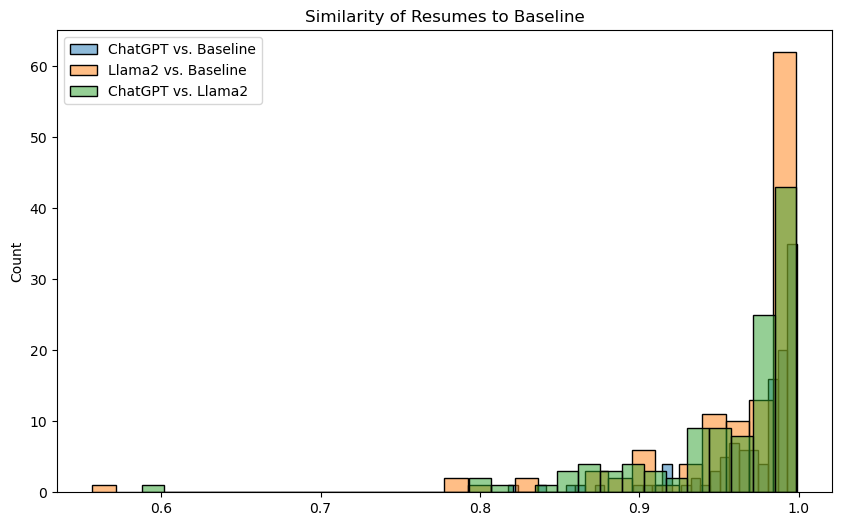

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(chatgpt_baseline_similarities, bins=30, alpha = 0.5, label = "ChatGPT vs. Baseline")
sns.histplot(llama2_baseline_similarities, bins=30, alpha = 0.5, label = "Llama2 vs. Baseline")
sns.histplot(chatgpt_llama2_similarities, bins=30, alpha = 0.5, label = "ChatGPT vs. Llama2")
plt.legend()
plt.title("Similarity of Resumes to Baseline");


In [ ]:
print(actual_resumes[0])

Scheduling Coordinator Scheduling Coordinator Scheduling Coordinator Insight Global Morrisville, NC Work Experience Scheduling Coordinator Insight Global March 2019 to Present Contract position with Cintas through Insight Global. Responsible for coordinating over 100 appointments daily, often valued over $100,000. Performed scheduling duties by making outbound calls to confirm and verify client information. Maintained organization and call data for reports while utilizing Excel and internal databases. Revise and provide SOW upon request. Project Manager Conversis June 2018 to March 2019 Permanent position. Ended due to branch closing. Managed translation and localization projects cost effectively, efficiently and to the highest quality standards. Closely governed each project or task, ensuring that client deadlines are met. Participated actively in client emails and meetings with clients, peers, translators, developers and managers. Successfully handled multiple projects at the same ti

In [65]:
llama2["00127"]

{'Basic_Info': {'Current_Title': 'Technical Representative',
  'Current_Company': '',
  'Location': 'Portland, OR',
  'Bio': ''},
 'Experience': [{'Job_Title': 'Technical Representative',
   'Company': '',
   'Location': '',
   'Start_Date': 'September 2018',
   'End_Date': 'Present',
   'Responsibilities': 'Manage 110 accounts across 14 western states to provide technical consulting, product applications and client training� � Facilitate client meetings, relations and devise plans for increased profitability� � Create demand via product marketing & positioning, market infiltration strategies, tradeshows & presentations and B2B sales� � Adapt to market fluctuations by generating new business with national distributors and manufacturers� � Provide industry knowledge and collaborate with R&D to shape new and improved product profiles'},
  {'Job_Title': 'R&D Manager, IPM Specialist, Database Administrator',
   'Company': 'Terra Nova Nurseries',
   'Location': '',
   'Start_Date': 'January

In [67]:
print(create_resume(llama2["00127"]).replace("\ufffd", "").replace("  ", ". "))

Technical Representative at 
Portland, OR

Experience:
Technical Representative at. September 2018 to Present
Manage 110 accounts across 14 western states to provide technical consulting, product applications and client training. Facilitate client meetings, relations and devise plans for increased profitability. Create demand via product marketing & positioning, market infiltration strategies, tradeshows & presentations and B2B sales. Adapt to market fluctuations by generating new business with national distributors and manufacturers. Provide industry knowledge and collaborate with R&D to shape new and improved product profiles
R&D Manager, IPM Specialist, Database Administrator at Terra Nova Nurseries January 2017 to September 2018
 Perpetuated new cultivar ideas & development to final patented products. Tracked data, provided photography and wrote product descriptions. Maintained plant health by developing fertilizer, lighting, pesticide and beneficial insect regiments. Propagated pl